In [1]:
#
# Compute FRET ratio from donor and acceptor image pair
#

In [2]:
%matplotlib inline
import numpy as np
from numpy import matlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import skimage.io
from skimage import filters, external, feature, transform, measure, morphology, color, restoration
from skimage import util, img_as_uint, img_as_float, img_as_ubyte
from skimage.segmentation import clear_border
import pandas as pd
import math
import os
from matplotlib import cm, colors, colorbar
from scipy.ndimage import fourier_shift

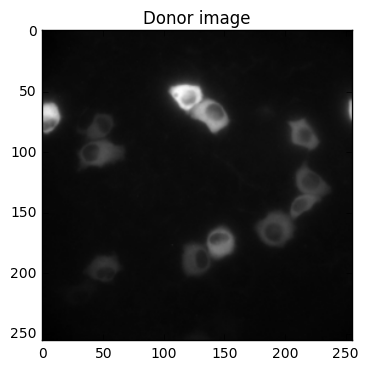

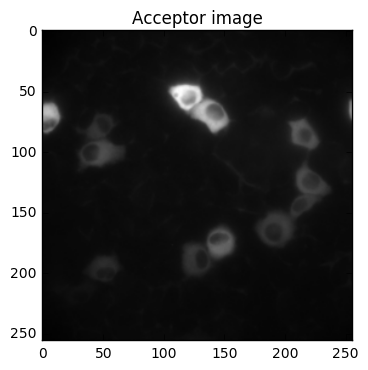

In [3]:
#
# Import image data
#
imd = img_as_float(skimage.io.imread('img/donor.tif'))
ima = img_as_float(skimage.io.imread('img/acceptor.tif'))
plt.figure()
plt.imshow(imd, cmap='gray')
plt.title('Donor image')
plt.figure()
plt.imshow(ima, cmap='gray')
plt.title('Acceptor image')
plt.show()

In [4]:
#
# (optional)
# Image registration between image pair at a sub-pixel level
#
shift, error, diffphase = feature.register_translation(imd, ima, 10)
print("Estimated shift = " + str(shift))
im = fourier_shift(np.fft.fftn(ima), shift)
ima = np.fft.ifftn(im).real
print("registration done.")

Estimated shift = [ 0.  -0.1]
registration done.


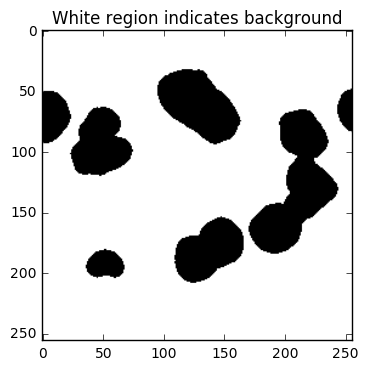

In [5]:
#
# remove background signal
#
def subtract_bg(img):
    img_blur = filters.gaussian(img, 1, mode='reflect',multichannel=False)
    thresh_otsu = filters.threshold_otsu(img_blur)
    mask = img > thresh_otsu * 0.5
    mask = morphology.binary_dilation(mask, selem=morphology.disk(7))
    mask = np.invert(mask)
    bg_median = np.median(img[mask])
    img_subtracted = img - bg_median
    return np.clip(img_subtracted, 0, 1), mask

imd_sbt, _ = subtract_bg(imd)
ima_sbt, mask = subtract_bg(ima)
plt.imshow(mask, cmap='gray')
plt.title('White region indicates background')
plt.show()

[]

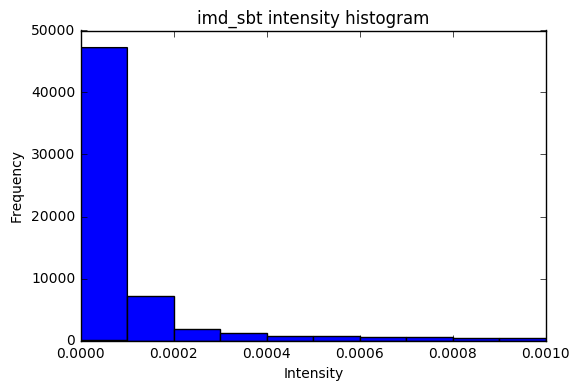

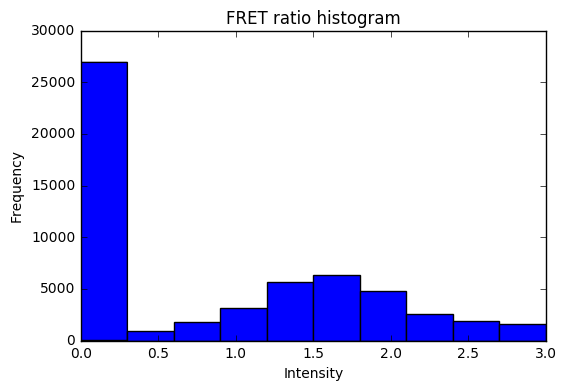

In [6]:
#
# (optional)
# check intensities 
#
plt.figure()
plt.hist(imd_sbt.flatten(), range=(0, 0.001))
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('imd_sbt intensity histogram')
plt.plot()

plt.figure()
ratio = np.divide(ima_sbt, imd_sbt + 1e-10)
plt.hist(ratio.flatten(), range=(0,3))
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('FRET ratio histogram')
plt.plot()

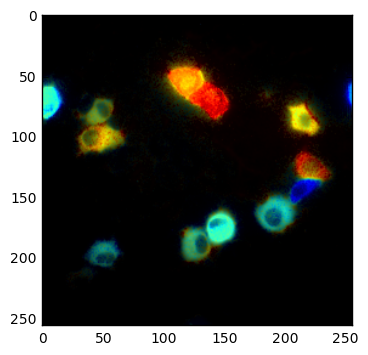

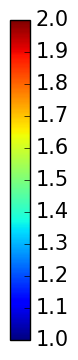

In [7]:
#
# compute ratio and visualize it
#
def myIMD(img_d, img_a, fret_min, fret_max, donor_min, donor_max):
    mask = (img_d - donor_min) / (donor_max - donor_min)
    mask = np.clip(mask, 0, 1)
    ratio = np.divide(img_a, img_d + 1e-10)
    ratio = (ratio - fret_min) / (fret_max - fret_min)
    ratio = np.clip(ratio, 0, 1)
    rgb = cm.jet(ratio)[:, :, :3]
    return np.multiply(rgb, np.tile(mask[:,:,np.newaxis], (1,1,3)))

fret_min = 1# to determine these values, look at the previous cell
fret_max = 2
donor_min = 0
donor_max = 0.002
imf = myIMD(imd_sbt, ima_sbt, fret_min, fret_max, donor_min, donor_max)
plt.imshow(imf)
#
# (optional) create a colorbar for presentation
#
fig = plt.figure(figsize=(1,4))
ax = fig.add_axes([0.05, 0.05, 0.2, 0.8])
cmap = cm.jet
norm = colors.Normalize(vmin=fret_min, vmax=fret_max)
cb = colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb.set_ticks(np.arange(fret_min, fret_max + 1e-3, 0.1))
cb.ax.tick_params(labelsize=15)